---
title: Harris and Hessian Corner Detection using OpenCV
author: "Guntas Singh Saran"
date: "2024-10-22"
format:
    html:
        code-fold: false
        code-tools: true
jupyter: python3
image: "output.png"
categories: ["Computer Vision"]

---

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from latex import latexify

latexify(columns = 2)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
image = cv2.imread('./images/B/board.jpg', 1)
print(image.shape)

(512, 512, 3)


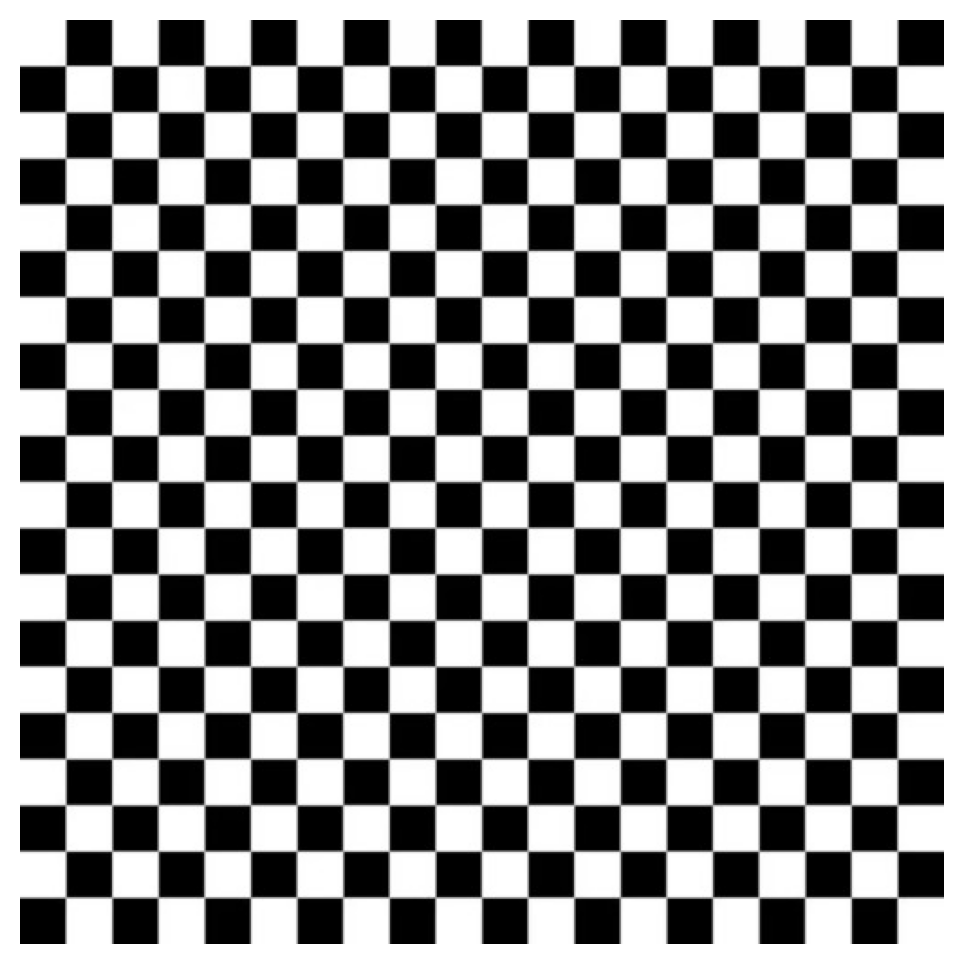

In [4]:
plt.figure(figsize=(6, 6))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

## Harris Corner Detection
Reference: https://medium.com/jun94-devpblog/cv-10-local-feature-descriptors-harris-and-hessian-corner-detector-7d524888abfd

In [3]:
from scipy.ndimage import convolve

def sobel_filter(image):
    Gx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype = np.float32)
    Gy = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], dtype = np.float32)
    
    img = image.astype(np.float32)
    img = cv2.GaussianBlur(img, (5, 5), 1.4)
    
    Ix = convolve(img, Gx, mode='constant', cval=0.0)
    Iy = convolve(img, Gy, mode='constant', cval=0.0)
    
    G = np.hypot(Ix, Iy)
    G = G / G.max() * 255
    G = G.astype(np.uint8)
    
    return np.clip(Ix, 0, 255).astype(np.uint8), np.clip(Iy, 0, 255).astype(np.uint8), G

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


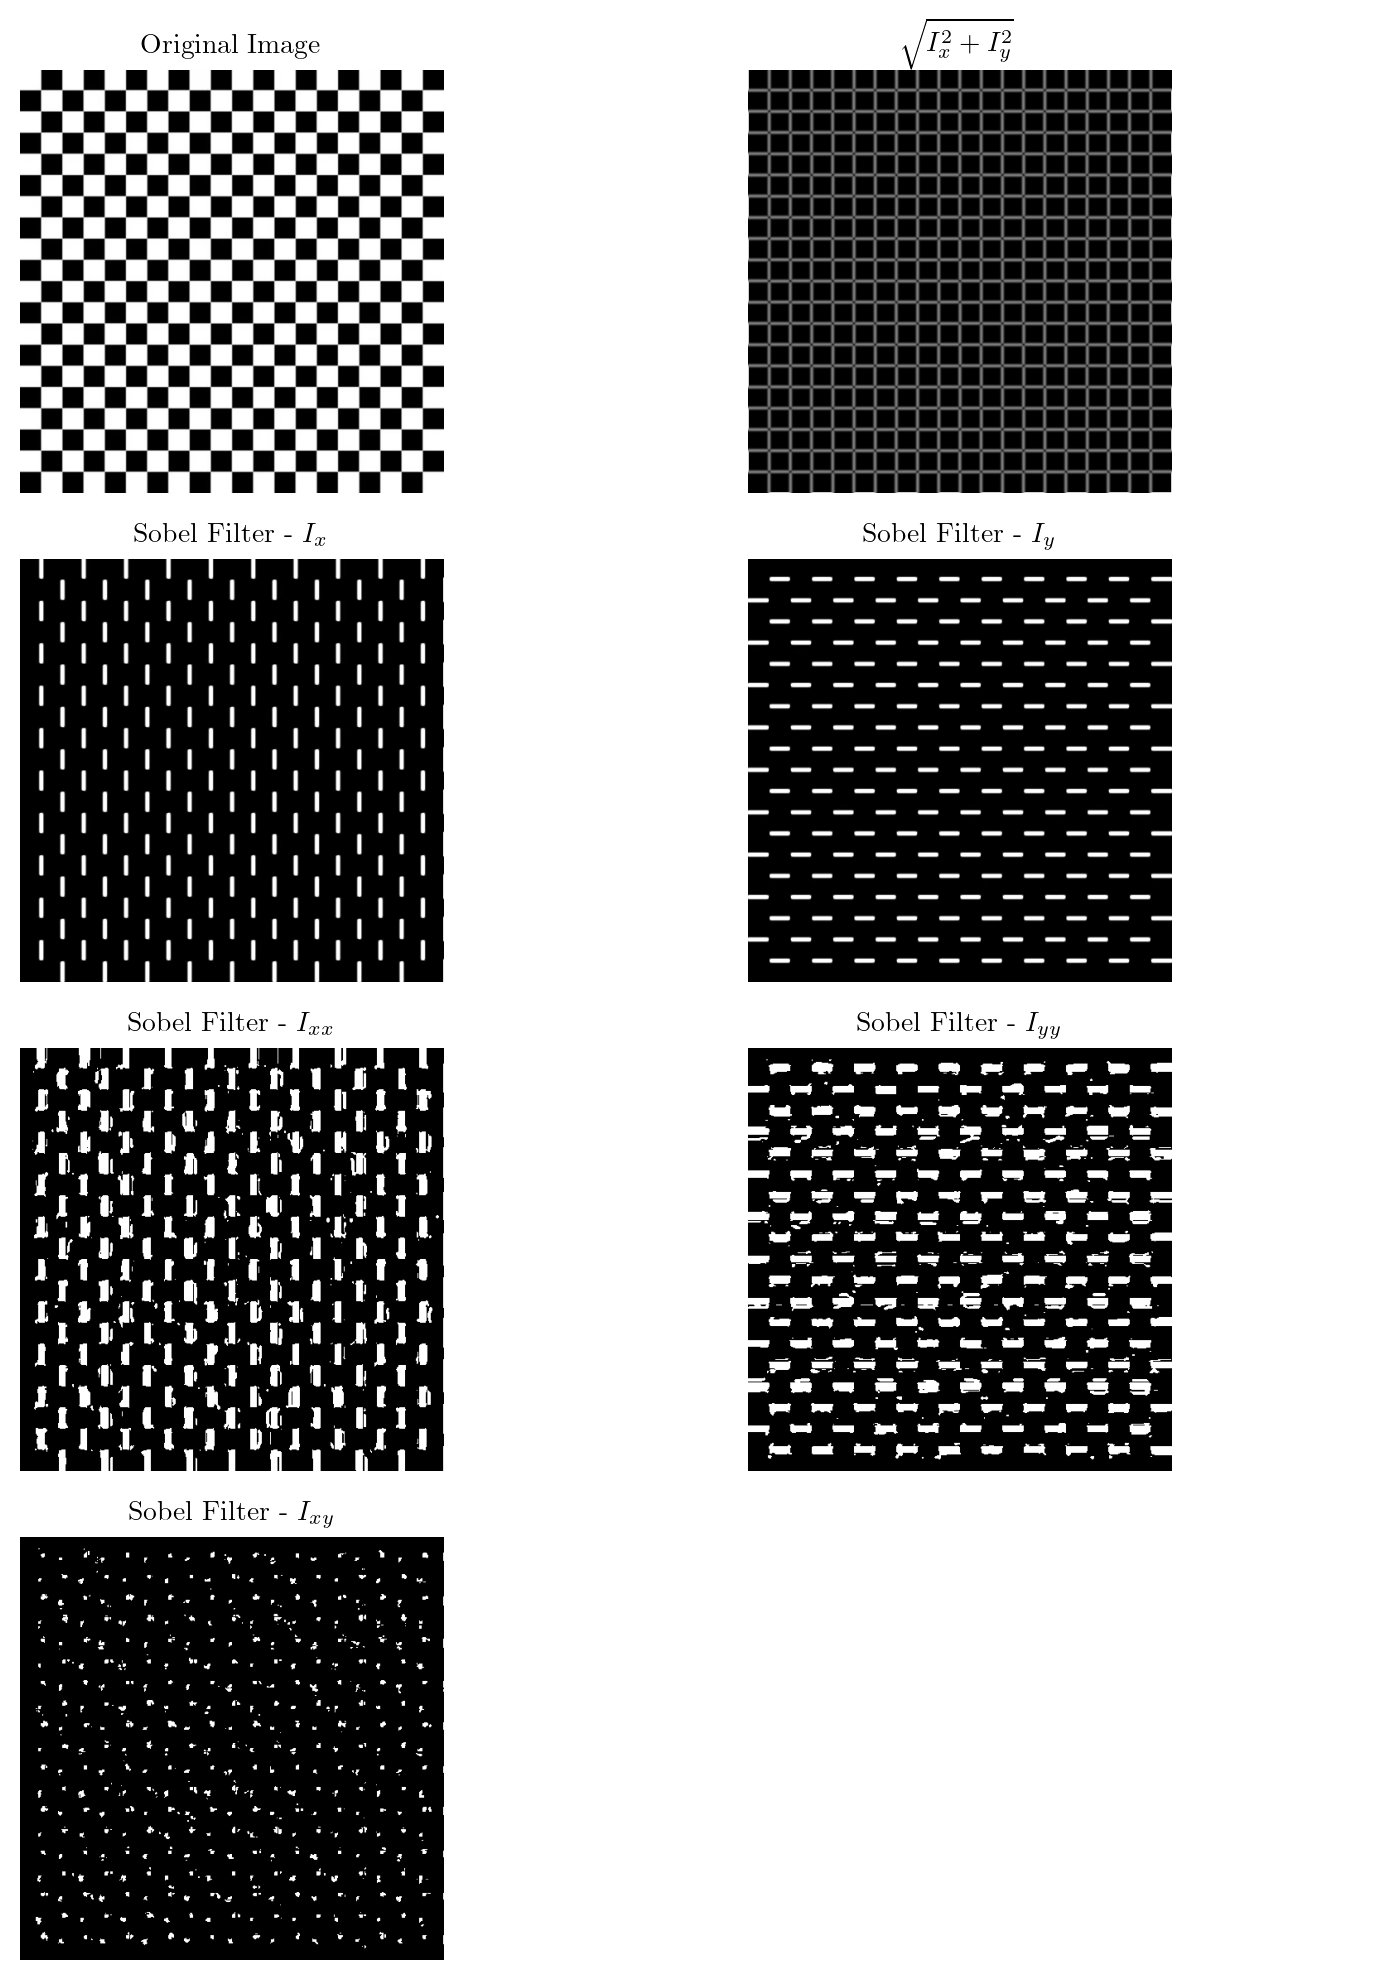

In [5]:
im = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
Ix, Iy, G = sobel_filter(im)

Ix_ = Ix.astype(np.float32)
Iy_ = Iy.astype(np.float32)
Ixx = Ix_**2
Iyy = Iy_**2
Ixy = Ix_ * Iy_

fig, axes = plt.subplots(4, 2, figsize=(8, 10))
axes[0, 0].imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
axes[0, 0].axis('off')
axes[0, 0].set_title('Original Image')

axes[0, 1].imshow(cv2.cvtColor(G, cv2.COLOR_BGR2RGB))
axes[0, 1].axis('off')
axes[0, 1].set_title(r'$\sqrt{I_x^2 + I_y^2}$')

axes[1, 0].imshow(cv2.cvtColor(Ix, cv2.COLOR_BGR2RGB))
axes[1, 0].axis('off')
axes[1, 0].set_title(r'Sobel Filter - $I_x$')

axes[1, 1].imshow(cv2.cvtColor(Iy, cv2.COLOR_BGR2RGB))
axes[1, 1].axis('off')
axes[1, 1].set_title(r'Sobel Filter - $I_y$')

axes[2, 0].imshow(cv2.cvtColor(Ixx, cv2.COLOR_BGR2RGB))
axes[2, 0].axis('off')
axes[2, 0].set_title(r'Sobel Filter - $I_{xx}$')

axes[2, 1].imshow(cv2.cvtColor(Iyy, cv2.COLOR_BGR2RGB))
axes[2, 1].axis('off')
axes[2, 1].set_title(r'Sobel Filter - $I_{yy}$')

axes[3, 0].imshow(cv2.cvtColor(Ixy, cv2.COLOR_BGR2RGB))
axes[3, 0].axis('off')
axes[3, 0].set_title(r'Sobel Filter - $I_{xy}$')

axes[3, 1].axis('off')

plt.tight_layout()
plt.show()

## Harris Corner Detector

The Harris corner detection method is based on the **structure tensor** (or second-moment matrix) $M$, which is computed from image gradients. The gradients $I_x$ and $I_y$ can be obtained using Sobel operators:

$$
G_x = \begin{bmatrix} -1 & 0 & 1 \\ -2 & 0 & 2 \\ -1 & 0 & 1 \end{bmatrix}, \quad G_y = \begin{bmatrix} 1 & 2 & 1 \\ 0 & 0 & 0 \\ -1 & -2 & -1 \end{bmatrix}
$$

Where:
- $G_x$ is the Sobel filter for calculating the horizontal gradient.
- $G_y$ is the Sobel filter for calculating the vertical gradient.


The image gradients $I_x$ and $I_y$ are computed as:

$$
I_x = G_x \ast I, \quad I_y = G_y \ast I
$$

The **structure tensor** $M$ is constructed using these gradients:

$$
M = \begin{bmatrix} I_x^2 & I_x I_y \\ I_x I_y & I_y^2 \end{bmatrix}
$$

The Harris response function $R$ is calculated as:

$$
R = \det(M) - k \cdot \text{trace}(M)^2
$$

Where:
- $\det(M) = I_x^2 I_y^2 - (I_x I_y)^2$ is the determinant of the matrix.
- $\text{trace}(M) = I_x^2 + I_y^2$ is the trace of the matrix.
- $k$ is a constant, typically $0.04$.

A corner is detected if $R$ exceeds a threshold, indicating significant changes in intensity in both gradient directions.

In [6]:
def detect_harris_corner(image, k=0.04, window_size=3, threshold=1e-4):
    if len(image.shape) == 3:
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray_image = image

    Ix, Iy, _ = sobel_filter(gray_image)

    Ix = Ix.astype(np.float32)
    Iy = Iy.astype(np.float32)

    Ixx = Ix ** 2
    Iyy = Iy ** 2
    Ixy = Ix * Iy

    Ixx = cv2.GaussianBlur(Ixx, (window_size, window_size), 1)
    Iyy = cv2.GaussianBlur(Iyy, (window_size, window_size), 1)
    Ixy = cv2.GaussianBlur(Ixy, (window_size, window_size), 1)

    # Harris response R = det(M) - k(trace(M))^2
    detM = Ixx * Iyy - Ixy ** 2
    traceM = Ixx + Iyy
    harris_response = detM - k * traceM ** 2

    harris_response = harris_response / harris_response.max()

    corners = np.zeros_like(harris_response)
    corners[harris_response > threshold] = 255

    return corners.astype(np.uint8), harris_response

def draw_corners_on_image(image, corners, radius=5, color=(0, 255, 0)):
    corner_img = image.copy()

    corner_points = np.argwhere(corners == 255)
    
    for point in corner_points:
        y, x = point
        cv2.circle(corner_img, (x, y), radius, color, 1)
    
    return corner_img

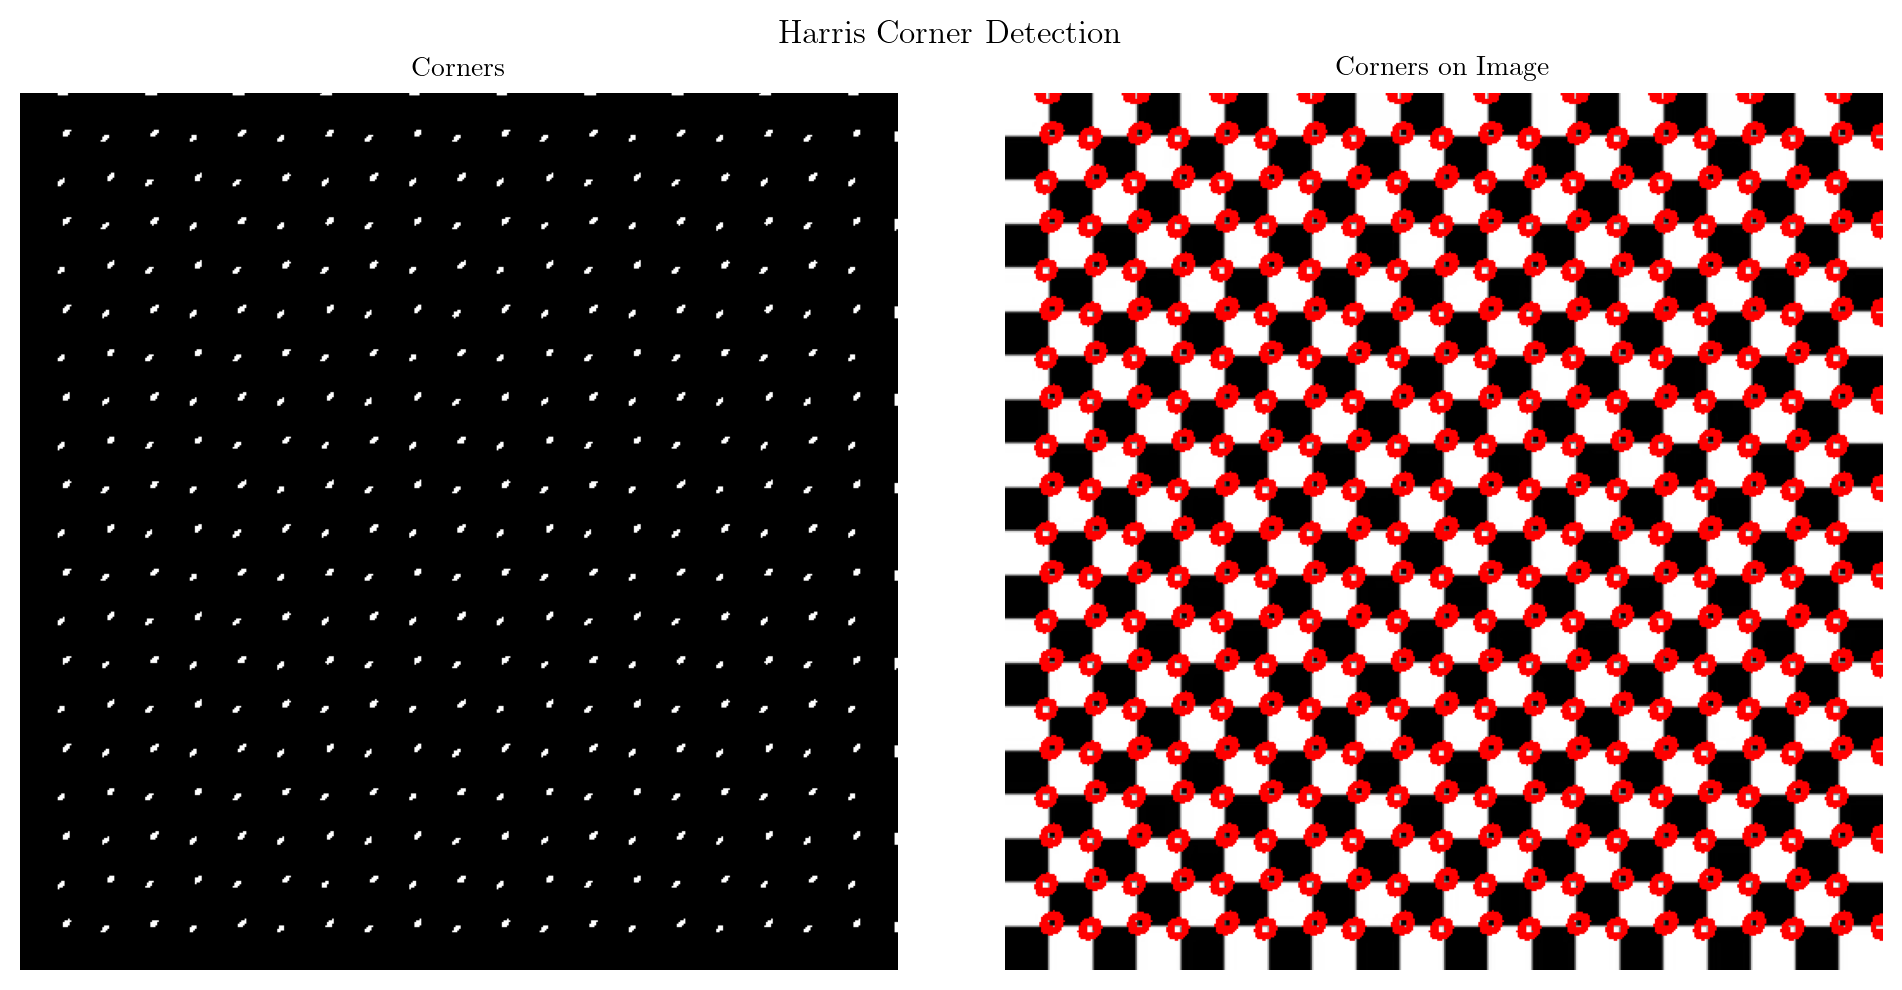

In [7]:
corners, harris_response = detect_harris_corner(image, k=0.04, window_size=3, threshold=0.01)

corners_image = draw_corners_on_image(image, corners, color = (255, 0, 0))

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Harris Corner Detection')
axes[0].imshow(corners, cmap='gray')
axes[0].axis('off')
axes[0].set_title('Corners')

axes[1].imshow(corners_image)
axes[1].axis('off')
axes[1].set_title('Corners on Image')

plt.tight_layout()
plt.show()

### Hessian Corner Detector

The Hessian corner detection method uses the **Hessian matrix**, which is computed from second-order derivatives of the image intensity. The second-order derivatives can be obtained using the following filters for the $x$ - and $y$ -directions:

$$
\frac{\partial^2}{\partial x^2} = \begin{bmatrix} 1 & -2 & 1 \\ 2 & -4 & 2 \\ 1 & -2 & 1 \end{bmatrix}, \quad
\frac{\partial^2}{\partial y^2} = \begin{bmatrix} 1 & 2 & 1 \\ -2 & -4 & -2 \\ 1 & 2 & 1 \end{bmatrix}, \quad
\frac{\partial^2}{\partial x \partial y} = \begin{bmatrix} -1 & 0 & 1 \\ 0 & 0 & 0 \\ 1 & 0 & -1 \end{bmatrix}
$$

The second-order derivatives are computed as:
$$
I_{xx} = \frac{\partial^2}{\partial x^2} \ast I, \quad I_{yy} = \frac{\partial^2}{\partial y^2} \ast I, \quad I_{xy} = \frac{\partial^2}{\partial x \partial y} \ast I
$$

The **Hessian matrix** $H$ is constructed using these derivatives:

$$
H = \begin{bmatrix} I_{xx} & I_{xy} \\ I_{xy} & I_{yy} \end{bmatrix}
$$

The response function for corner detection is the Hessian determinant:

$$
R_H = \det(H) = I_{xx} I_{yy} - I_{xy}^2
$$

Corners are detected where $R_H$ is large, indicating significant curvature in both directions.

In [8]:
def sobel_second_order(image):

    Dxx = np.array([[1, -2, 1], [2, -4, 2], [1, -2, 1]], dtype=np.float32)
    Dyy = Dxx.T
    Dxy = np.array([[1, 0, -1], [0, 0, 0], [-1, 0, 1]], dtype=np.float32)

    img = image.astype(np.float32)
    img = cv2.GaussianBlur(img, (5, 5), 1.4)

    Ixx = convolve(img, Dxx, mode='constant', cval=0.0)
    Iyy = convolve(img, Dyy, mode='constant', cval=0.0)
    Ixy = convolve(img, Dxy, mode='constant', cval=0.0)

    return Ixx, Iyy, Ixy

def detect_hessian_corner(image, threshold=1e-4):

    if len(image.shape) == 3:
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray_image = image

    Ixx, Iyy, Ixy = sobel_second_order(gray_image)

    Ixx = Ixx.astype(np.float32)
    Iyy = Iyy.astype(np.float32)
    Ixy = Ixy.astype(np.float32)

    # Hessian response R = det(H)
    detH = Ixx * Iyy - Ixy ** 2

    # Normalize the response for better visualization
    detH = detH / np.max(detH)

    # Apply threshold to get corner points
    corners = np.zeros_like(detH)
    corners[detH > threshold] = 255

    return corners.astype(np.uint8), detH

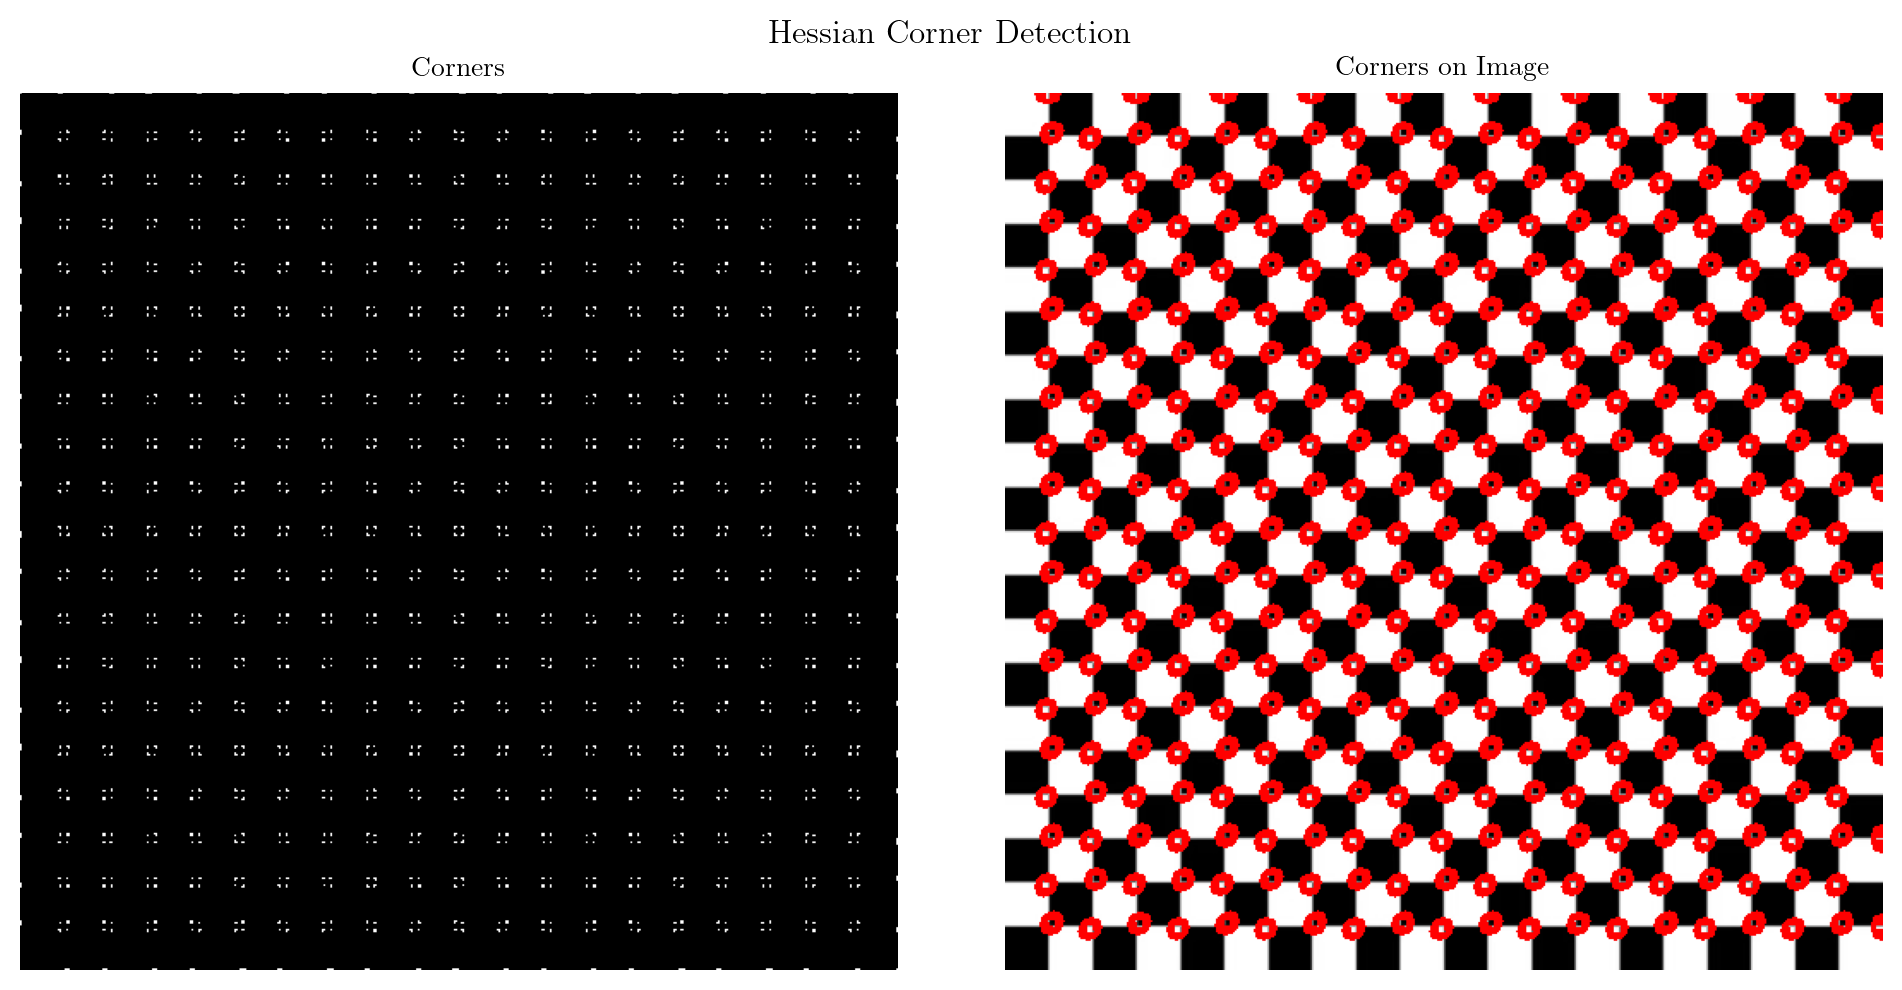

In [9]:
corners, hessian_response = detect_hessian_corner(image, threshold=0.01)
corner_image = draw_corners_on_image(image, corners, radius=5, color=(0, 255, 0))

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Hessian Corner Detection')
axes[0].imshow(corners, cmap='gray')
axes[0].axis('off')
axes[0].set_title('Corners')

axes[1].imshow(corners_image)
axes[1].axis('off')
axes[1].set_title('Corners on Image')

plt.tight_layout()
plt.show()